In [8]:
from __future__ import unicode_literals, print_function, division
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")
import time
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from functools import partial
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

plt.ion()

In [2]:

#################LOAD DATA############################
path = "C:/Users/Tony/Documents/TestData/data/"
dataset = pd.read_csv(path+"low_dataset.csv")

In [3]:
####Split the dataset into low, muffled, normal and high
def split_dataset():
    list_utterance_type = ["low", "muffled", "normal", "high"]
    for type in list_utterance_type:
        data = dataset[dataset["script_id"].str.contains(type)]
        data.to_csv(path+type+"_dataset.csv", index=False)

In [429]:
SOS_token = 0
EOS_token = 0

class Mydataset(Dataset):
    def __init__(self, inputs, targets):
        self.targets = targets
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def get_au_dictionary(dataframe):
    dic = {}
    groups = dataframe.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = dataframe.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        dic[key] = au
    return dic

def prepare_data(data, only_bs=True):
    ##pairs are same script name over n number of lines
    ##while name is not different, take the first 17 au columns, and the last 61 columns (ARKIT results) to form a pair
    ##return a list of pairs of dataframe
    pairs = []
    groups = data.groupby('script_id').groups #group by duplicates script_id and return a dictionary of indexes where the key is the script_id and the value is a list of indexes
    for key, val in groups.items():
        dt_indexed = data.iloc[val]  #iloc is for integer indexing
        au = dt_indexed.loc[:, dt_indexed.columns.str.endswith("_r")] #loc is for label indexing
        bs = dt_indexed.iloc[:, -61:] #selects the last 61 columns corresponding to blendshapes + eyes rotation and head rotation in 3 axes (+ 9 variables) )
        if only_bs:
            bs = bs.iloc[:, :-9] #Drop the 9 columns not related to blendshapes (eyes + head rotation)
        length = au.shape[0]
        pairs.append((au, bs, length))
    return pairs

def sort_pairs(pairs):
    return [(inp, tgt, l) for inp, tgt, l in pairs if l < MAX_LENGTH ]
    

def my_collate_fn(batch):
    #sort batch in descending order
    #Batch is list of tuples
    inp = [x[0] for x in batch]
    tgt = [x[1] for x in batch]
    sorted_inp = sorted(inp, key=lambda x: x.shape[0], reverse=True)
    sorted_tgt = sorted(tgt, key=lambda x: x.shape[0], reverse=True)
    #get a list of each batch length
    lengths_of_batches = torch.LongTensor([x.shape[0] for x in sorted_inp])
    input_tensors = [torch.FloatTensor(inp).to(device) for inp in sorted_inp]
    target_tensors = [torch.FloatTensor(tgt).to(device) for tgt in sorted_tgt]
    padded_input = torch.nn.utils.rnn.pad_sequence(input_tensors)
    padded_target = torch.nn.utils.rnn.pad_sequence(target_tensors)
    return padded_input, padded_target, lengths_of_batches

#padded sequence
def get_dataloader(batch_size, data, train_data_percentage=0.7, test_data_percentage=0.2,short_sentences=False, only_bs=True):
    if train_data_percentage + test_data_percentage >= 1:
        print("train + test data_percentage must be lower than 1. You need room for the valid dataset")
        return
    pairs = prepare_data(data, only_bs=only_bs)
    if short_sentences:
        pairs = sort_pairs(pairs)
    inputs = [x[0].to_numpy() for x in pairs]
    targets = [x[1].to_numpy() for x in pairs]
    data = Mydataset(inputs, targets)
    generator = torch.Generator().manual_seed(42) #for reproductability
    train_size = int(train_data_percentage * len(data))
    test_size = int(test_data_percentage*len(data))
    val_size = int(len(data) - train_size - test_size)
    train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, val_size, test_size], generator=generator)
    
    train_sampler = RandomSampler(train_dataset)
    test_sampler = RandomSampler(test_dataset)
    valid_sampler = RandomSampler(validation_dataset)

    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    validation_dataloader = DataLoader(validation_dataset, sampler=valid_sampler, batch_size=batch_size, collate_fn=my_collate_fn)
    return [train_dataloader, validation_dataloader, test_dataloader]


In [689]:
torch.autograd.set_detect_anomaly(True)

#From StackOverflow : https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, model, criterion):
        if validation_loss < self.min_validation_loss:
            torch.save(model.state_dict(), f"pytorch models/{model.__class__.__name__}_{criterion.__class__.__name__}_low.pth")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


class GRUNet(nn.Module):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)
        self.relu = nn.ReLU()

    def forward(self, input_tensor):
        output, _ = self.gru(input_tensor)
        output = self.linear(output)
        output = self.dropout(output)
        output = self.relu(output)
        return output

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        self.train()
        for batch in dataloader:
            input_tensor, target_tensor, l = batch
            optimizer.zero_grad()
            outputs = self.forward(input_tensor)
            loss = self.loss_comp(outputs, target_tensor, criterion, l)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)
    
    def loss_comp(self, out, target, criterion, l=None):
        return criterion(out.view(-1), target.view(-1))

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                out = self.forward(inp)
                loss += self.loss_comp(out, tgt, criterion).item()
        return loss / len(valid_dataloader)
    
    def train_(self, train_dataloader, valid_dataloader, n_epochs, criterion, optimizer):
        train_loss = []
        valid_loss = []
        last_epoch = 0
        early_stopper = EarlyStopper(patience=5)
        for epoch in range(1, n_epochs + 1):
            tloss = self.train_epoch(train_dataloader, optimizer, criterion)
            vloss = self.evaluate_epoch(valid_dataloader, criterion)
            train_loss.append(tloss)
            valid_loss.append(vloss)
            last_epoch = epoch
            if early_stopper.early_stop(vloss, self, criterion):
                break
            print(f"epoch: {epoch}\n   train loss: {tloss}\t valid loss: {vloss}")
        plt.plot(train_loss, label="train loss")    
        plt.plot(valid_loss, label="valid loss")
        plt.legend(loc="upper right")
        plt.xlabel(f"epochs: ({last_epoch})")
        plt.ylabel("loss amplitude")
        plt.title(f"train {criterion.__class__.__name__} | {self.__class__.__name__}")

class GRUNetNeg(GRUNet):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)

    def loss_comp(self, out, target, criterion, l=None):
        loss = criterion(out.view(-1), target.view(-1)) + torch.mean(NegRELU(out.view(-1)))
        return loss

class GRUNetPack(GRUNet):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)

    def forward(self, input_tensor):
        gru_output, _ = self.gru(input_tensor)
        pad_output, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_output)
        linear_out = self.linear(pad_output)
        output = self.dropout(linear_out)
        output = self.relu(output)
        return output


    def loss_comp(self, output, target, criterion, l):
        loss = 0
        pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target, l)
        for pred, tgt in zip(pred_list, target_list):
            loss += criterion(pred.view(-1), tgt.view(-1))
        return loss

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss = 0
        self.train()
        for batch in dataloader:
            input_tensor, target_tensor, sequence_lengths = batch
            loss = 0
            input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=sequence_lengths)
            optimizer.zero_grad()
            outputs = self.forward(input_gru)
            loss = self.loss_comp(outputs, target_tensor, criterion, sequence_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=l)
                out = self.forward(input_gru)
                loss += self.loss_comp(out, tgt, criterion, l).item()
        return loss / len(valid_dataloader)

class GRUNetSeq(GRUNetPack):
    def __init__(self, input_size=17, hidden_size=128, output_size=61, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p=dropout_p)
        self.encoder = nn.GRU(input_size, hidden_size)
        self.decoder = nn.GRU(input_size+hidden_size, hidden_size) #concat input and context vector
        self.linear = nn.Linear(input_size + hidden_size*2, output_size) #concat input, hidden and context vectors
        self.tgr_len = 0
        self.batch_size = 0

    def _init(self, input_pack_tensor):
        #input = [sequence_length, batch_size, input_size]
        #target = [sequence_length, batch_size, output_size]
        input_pad, _ =  torch.nn.utils.rnn.pad_packed_sequence(input_pack_tensor)
        self.batch_size = input_pad.shape[1] 
        self.trg_len = input_pad.shape[0]
        enc_outputs, enc_hid = self.encoder(input_pack_tensor)
        return input_pad, enc_outputs, enc_hid

    def forward(self, input_pack_tensor):
        input_pad, enc_outputs, enc_hid = self._init(input_pack_tensor)
        hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(device) #hidden = [1, batch_size, hidden_size]
        outputs = torch.zeros(self.trg_len, self.batch_size, self.output_size).to(device)

        for t in range(0, self.trg_len):
            inp = input_pad[t] #inp [4, input_size]
            inp = inp.unsqueeze(0) #inp [1, 4, input_size], gru accepts 3D batched tensors, this adds a new dimension at position 0
            input_context = torch.cat((inp, enc_hid), dim = 2) #input_contex = [1, 4, input_size+hidden_size]
            output, hidden = self.forward_step(input_context, hidden, enc_hid, inp)
            #output = [batch_size, output_size]
            outputs[t] = output
        return outputs # outputs = [batch_size, sequence lengths, output size]

    def forward_step(self, input_context, hidden, enc_hid, inp):
        output, hidden = self.decoder(input_context, hidden)
        #hidden = [1, 4, hidden_size]
        fc_input = torch.cat((inp.squeeze(0), hidden.squeeze(0), enc_hid.squeeze(0)), dim=1)
        output = self.linear(fc_input)
        return output, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, hidden, enc_output):
        hidden = hidden.unsqueeze(1).repeat(1, enc_output.shape[0], 1)
        # hidden = [seq_len, batch_size, hidden]
        enc_output = enc_output.permute(1, 0, 2)
        #encoder output = [seq_len, batch_size, hidden]
        energy = torch.tanh(self.Wa(hidden) + self.Ua(enc_output))  # Calculate energy for each sequence element
        scores = self.Va(energy).squeeze(2)  # Linear transformation and squeeze
        
        weights = F.softmax(scores, dim=1)  # Apply softmax to get attention weights
        context = torch.bmm(weights.unsqueeze(1), enc_output).squeeze(1)  # Calculate context vector

        return context, weights

class GRUNetAtt(GRUNetSeq):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1): #17
        super().__init__(input_size, hidden_size, output_size, dropout_p)
        self.attention = BahdanauAttention(hidden_size)
        self.decoder = nn.GRU(input_size+hidden_size, hidden_size)
        self.linear = nn.Linear(input_size+hidden_size*2, output_size)

    def forward(self, input_pack_tensor):
        input_pad, enc_outputs, enc_hid = self._init(input_pack_tensor)
        hidden = enc_hid #hidden = encoder hidden
        outputs = torch.zeros(self.trg_len, self.batch_size, self.output_size).to(device)
        enc_outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(enc_outputs, batch_first=False) #enc_outputs = [seq_len, batch_size, hidden_size]

        for t in range(0, self.trg_len):
            inp = input_pad[t] #inp [4, input_size]
            inp = inp.unsqueeze(0) #inp [1, 4, input_size]
            output, hidden = self.forward_step(enc_outputs, hidden, inp)
            #output = [batch_size, output_size]
            outputs[t] = output
        return outputs # outputs = [batch_size, sequence lengths, output size]

    def forward_step(self, enc_outputs, hidden, inp):
        context, _ = self.attention(hidden.squeeze(0), enc_outputs)
        context = context.unsqueeze(0) #context = [1, batch_size, hid]
        input_gru = torch.cat((inp, context), dim=2) #input gru = [1, batch_size, input_size + hidden_size]
        output, hidden = self.decoder(input_gru, hidden) #output = hidden = [1, batch_size, hidden_size]
        fc_input = torch.cat((output.squeeze(0), context.squeeze(0), inp.squeeze(0)), dim=1) #fc_input = [1, batch_size, input_size+hidden*3]
        output = self.linear(fc_input) #output = [1, batch_size, output_size]

        return output, hidden

class GRUNetSig(GRUNet):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super().__init__(input_size, hidden_size, output_size, dropout_p)
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size, self.hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, device=device)
        self.linear2 = nn.Linear(input_size, output_size, device=device)
        self.sig = nn.Sigmoid()

    def forward(self, input_packed):
        gru_output, _ = self.gru(input_packed)
        pad_output, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_output)
        input2, _ = torch.nn.utils.rnn.pad_packed_sequence(input_packed)
        linear_out = self.linear(pad_output)
        activation_probability = self.linear2(input2)
        activation_probability = self.sig(activation_probability)
        return linear_out, activation_probability

    def loss_comp(self, output, target, prob, criterion, l):
        loss = 0
        bce_loss = 0
        out_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target.clone(), l)
        prob_list = torch.nn.utils.rnn.unpad_sequence(prob.clone(), l)
        for p, t, prob in zip(out_list, target_list, prob_list):
            tr = nn.Threshold(0.5, 0)
            threshold = tr(prob) #If prob values are lower than 0.5, they become 0
            new_p = threshold*p
            loss += criterion(new_p.view(-1), t.view(-1))
            bce_loss += my_bce_loss(prob, t)
        return (loss)+(bce_loss/4)

    def train_epoch(self, dataloader, optimizer, criterion):
        total_loss=0
        self.train()
        for batch in dataloader:
            optimizer.zero_grad()
            input_tensor, target_tensor, lengths = batch
            input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=lengths)
            out, out_pred = self.forward(input_gru)
            loss = self.loss_comp(out, target_tensor, out_pred, criterion, lengths)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        return total_loss / len(dataloader)   

    def evaluate_epoch(self, valid_dataloader, criterion):
        loss = 0
        self.eval()
        with torch.no_grad():
            for batch in valid_dataloader:
                inp, tgt, l = batch
                input_gru = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=l)
                out, prob = self.forward(input_gru)
                loss += self.loss_comp(out, tgt, prob, criterion, l).item()
        return loss / len(valid_dataloader)   

class FCNet(GRUNet):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__(input_size, hidden_size, output_size)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input_tensor):
        out = self.linear1(input_tensor)
        out = self.linear2(out)
        out = self.out(out)
        out = self.relu(out)
        return out
    
    def loss_comp(self, output, target, criterion, l):
        loss = 0
        pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), l)
        target_list = torch.nn.utils.rnn.unpad_sequence(target, l)
        for pred, tgt in zip(pred_list, target_list):
            loss += criterion(pred.view(-1), tgt.view(-1))
        return loss   

def NegRELU(tensor): ##Custom loss function to penalize negative values
    relu = nn.ReLU()
    return relu(torch.neg(tensor))

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, inp, target):
        mse = torch.mean((inp - target) ** 2)
        rmse = torch.sqrt(mse + 1e-7)
        return rmse

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)

def compute_loss(prediction_padded, target_padded, lengths, criterion, computeEachBsLoss, batch_first, prob_padded=None):
    """
    Tactics 1:
        unpad all the sequences to get rid of the 0 padding
        compute the loss with  loss = criterion(pred.view(-1, pred.size(-1)), target_tensor.view(-1, target_tensor.size(-1))).sum()
    Tactics 2: get a list of loss for corresponding blendshapes
        create a mask before-hand, to tell where is the 0 padding
    """
    loss_arr = torch.zeros(52).to(device)
    loss = 0
    loss_bce = 0
    if computeEachBsLoss:
        ###Permute dimension and flatten the tensors to have a shape [52, sequence_length*batch_size], allow to compute loss for each 52 blendshapes
        array = criterion(torch.flatten(prediction_padded.permute(2, 0, 1), start_dim=1), torch.flatten(target_padded.permute(2, 0, 1), start_dim=1))
        loss_arr += torch.mean(array, dim=1)
        loss = torch.sum(loss_arr)
    elif prob_padded!=None:
        pred_list = torch.nn.utils.rnn.unpad_sequence(prediction_padded, lengths, batch_first=batch_first)
        target_list = torch.nn.utils.rnn.unpad_sequence(target_padded, lengths, batch_first=batch_first)
        prob_list = torch.nn.utils.rnn.unpad_sequence(prob_padded, lengths, batch_first=batch_first)
        for p, t, prob in zip(pred_list, target_list, prob_list):
            tr = nn.Threshold(0.5, 0)
            new_p = p*tr(prob)
            loss +=criterion(new_p, t)
            loss_bce += my_bce_loss(p, t)
    else:
        pred_list = torch.nn.utils.rnn.unpad_sequence(prediction_padded, lengths, batch_first=batch_first)
        target_list = torch.nn.utils.rnn.unpad_sequence(target_padded, lengths, batch_first=batch_first)
        for p, t in zip(pred_list, target_list):
            loss +=criterion(p, t)
    return loss+loss_bce/4, loss_arr

def my_bce_loss(x, y): ###Custom BCE
    activated = (y != 0).float().clamp(min=1e-10)
    unactivated = (y == 0).float().clamp(min=1e-10)
    Tr = nn.Threshold(0.5, 1e-10)
    act_x = Tr(x)
    unact_x = (x - act_x).clamp(min=1e-10)
    loss = -1.0 * (torch.log(act_x)*activated + torch.log(unact_x)*unactivated)
    return loss.mean()

def train_epoch(seqModel, dataloader, optimizer, criterion, usePackTensor=False, computeEachBsLoss=False, batch_first=True, enforce_sorted=False, with_bce=False):
    total_loss = 0
    loss_for_each_bs = torch.zeros(52).to(device)
    for batch in dataloader:
        input_tensor, target_tensor, lengths = batch
        optimizer.zero_grad()
        if usePackTensor:
            input_tensor = torch.nn.utils.rnn.pack_padded_sequence(input=input_tensor, lengths=lengths, batch_first=batch_first, enforce_sorted=enforce_sorted)
        if with_bce:
            out, out_pred = seqModel(input_tensor, target_tensor)
            outputs_clone = out.clone()
            out_pred_clone = out_pred.clone()
            loss, loss_arr = compute_loss(outputs_clone, target_tensor, lengths, criterion, computeEachBsLoss, batch_first, out_pred_clone)
        else:
            out = seqModel(input_tensor, target_tensor)
            loss, loss_arr = compute_loss(out, target_tensor, lengths, criterion, computeEachBsLoss, batch_first, None)
        if computeEachBsLoss:
            loss_for_each_bs += loss_arr
        loss.backward()
        torch.nn.utils.clip_grad_norm_(seqModel.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader), loss_for_each_bs / len(dataloader)

def train(train_dataloader, seqModel, n_epochs, learning_rate=0.001,
          print_every=100, plot_every=100, usePackTensor=False, usecomputeLossForBs=False, batch_first=True, enforce_sorted=False, with_bce=False):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    loss_bs = []
    optimizer = optim.Adam(seqModel.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss() #reduction = mean by default
    if usecomputeLossForBs:
        criterion = nn.MSELoss(reduction="none")
    for epoch in range(1, n_epochs + 1):
        loss, loss_for_each_bs = train_epoch(seqModel, train_dataloader, optimizer, criterion, usePackTensor=usePackTensor, computeEachBsLoss=usecomputeLossForBs, batch_first=batch_first, enforce_sorted=enforce_sorted, with_bce=with_bce)
        #loss = seqModel.train_epoch(train_dataloader, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        #loss_bs.append(loss_for_each_bs)
        if epoch % print_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            print(f"epoch: {epoch}\tloss: {plot_loss_avg}")
    plt.plot(np.arange(0, len(plot_losses)*plot_every, plot_every), plot_losses)
    plt.xlabel(f"epochs ({len(plot_losses)})")
    plt.ylabel(f"loss {criterion.__class__.__name__}")
    return loss_bs

In [385]:
hidden_size = 128
batch_size = 4
input_size = 17 # action units
output_size = 52 # blendshapes
lr=0.001

In [255]:
savedModel = torch.load("pytorch models/model_0.7.pth")

In [603]:
####Load data
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(batch_size=batch_size, data=dataset, short_sentences=False, only_bs=True)
print(f"train size: {len(train_dataloader.dataset)}, valid size: {len(valid_dataloader.dataset)}, test size: {len(test_dataloader.dataset)}")

train size: 656, valid size: 95, test size: 187


656 187
epoch: 1
   train loss: 38.001971430894805	 valid loss: 36.23507642745972
epoch: 2
   train loss: 37.60193408407816	 valid loss: 35.96933261553446
epoch: 3
   train loss: 37.37091222623499	 valid loss: 35.766459147135414
epoch: 4
   train loss: 37.19405191700633	 valid loss: 35.614813486735024
epoch: 5
   train loss: 37.05662641292665	 valid loss: 35.48934809366862
epoch: 6
   train loss: 36.94708470600407	 valid loss: 35.393167654673256
epoch: 7
   train loss: 36.86033241923263	 valid loss: 35.312378327051796
epoch: 8
   train loss: 36.78922154263752	 valid loss: 35.2497771581014
epoch: 9
   train loss: 36.73062823458416	 valid loss: 35.194206635157265
epoch: 10
   train loss: 36.68285597824469	 valid loss: 35.150173823038735
epoch: 11
   train loss: 36.642000244884954	 valid loss: 35.10766084988912
epoch: 12
   train loss: 36.606965053372264	 valid loss: 35.0761992931366
epoch: 13
   train loss: 36.57729732699511	 valid loss: 35.04572296142578
epoch: 14
   train loss: 36.5521

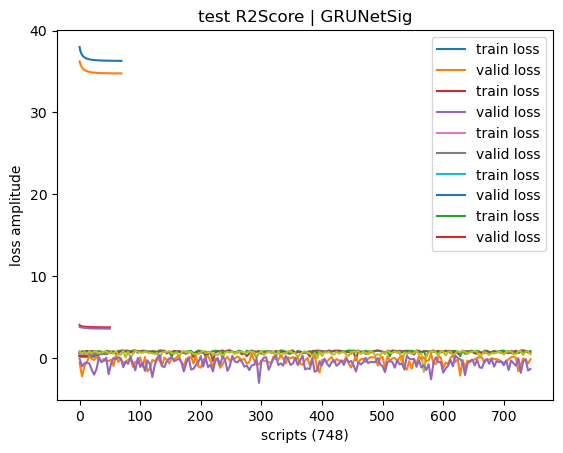

In [693]:
%matplotlib inline
import sys
from contextlib import redirect_stdout
from torchmetrics.regression import R2Score

torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
alpha = a
seqModel = GRUNetSig(input_size, hidden_size, 52).to(device)
seqModel.apply(init_weights)
optimizer = optim.Adam(seqModel.parameters(), lr=lr)
criterion = RMSELoss()
start_time = time.time()
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
seqModel.train_(train_dataloader, valid_dataloader, n_epochs=100, criterion=criterion, optimizer=optimizer)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
def find_best_hparam(config, data):
    model = GRUNet03(input_size, config["h"], output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    train_dataloader, test_dataloader = get_dataloader(batch_size=int(config["batch_size"]), data=data, with_test_data=True, train_data_percentage=0.8)
    criterion = torch.nn.MSELoss()

    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        model.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch=0
    
    plot_losses = []
    for epoch in range(start_epoch, 20):
        loss = model.train_epoch(train_dataloader, optimizer, criterion)
        plot_losses.append(loss)
        print(f"epoch: {epoch}\tloss: {loss}")
        plot_losses.append[loss]
    checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
    checkpoint = Checkpoint.from_dict(checkpoint_data)

    session.report(
            {"loss": torch.sum(plot_losses) / len(plot_losses)},
            checkpoint=checkpoint,
        )

def start_fine_tuning():
    config = {
        "lr": tune.loguniform(1e-5, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16, 32]),
        "h": tune.choice([2 ** i for i in range(10)])
    }

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=20,
        grace_period=1,
        reduction_factor=2
    )

    result = tune.run(
        tune.with_parameters(find_best_hparam, data=dataset),
        config=config,
        num_samples=10,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")

    best_trained_model = GRUNet03(input_size, best_trial.config["h"], output_size).to(device)
    best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])
    evaluate2(best_trained_model, test_dataloader, batch_first=False)

In [ ]:
# list_of_bs = [[] for i in range(52)]
# for i, l in enumerate(loss_bs):
#     for j, val in enumerate(l):
#         list_of_bs[j].append(val.item())

def save_loss_for_each_bs(loss_bs):
    columns = dataset.columns[-61:]
    columns = columns[:-9] #remove 9 last columns
    loss_detach = [[val.item for val in l] for l in loss_bs]
    np_list = np.array(loss_detach)
    for i, l in enumerate(np_list.transpose()):
        _, ax = plt.subplots()
        ax.plot(np.arange(0, len(l)), l)
        ax.title.set_text(columns[i])
        plt.savefig("bs_loss/" + columns[i] + "loss.png")

In [682]:
%matplotlib inline
from torchmetrics.regression import R2Score
def evaluate(criterion, model, test_data, computeEachBsLoss=False, use_pack=True, with_prob=False):
        model.eval()
        total_loss = 0
        plot_loss = []
        predictions = []
        activation_precision = []
        activation_recall = []
        loss_list = []
        loss_arr = torch.zeros(52).to(device)
        with torch.no_grad():
            for inp, tgt, sequence_lengths in test_data:
                loss_by_batch = []
                if computeEachBsLoss:
                    output = model(inp)
                    criterion = nn.MSELoss(reduction="none")
                    compute_loss_bs_wise(criterion, output, tgt, plot_loss, activation_precision, activation_recall)
                elif use_pack:
                    inp = torch.nn.utils.rnn.pack_padded_sequence(input=inp, lengths=sequence_lengths)
                    if with_prob:
                        output, prob = model(inp)
                        compute_loss_function(criterion, output, tgt, sequence_lengths, activation_precision, activation_recall, plot_loss, loss_by_batch, prob)
                if (use_pack and not with_prob) or (not use_pack and not with_prob):
                    output = model(inp)
                    compute_loss_function(criterion, output, tgt, sequence_lengths, activation_precision, activation_recall, plot_loss, loss_by_batch)
                #Predictions is a list of tuples, output has the shape L*Batch*blendshape counts, sequence lengths will be useful to cut script values
                predictions.append((inp, output, sequence_lengths))
        print(f'mean  {criterion.__class__.__name__}: {np.mean(plot_loss)}')
        print(f"mean activation precision: {np.mean(activation_precision)}")
        print(f"mean activation recall: {np.mean(activation_recall)}")
        plt.plot(np.arange(0, len(plot_loss)*batch_size, batch_size), plot_loss)
        plt.xlabel(f"scripts ({len(plot_loss)*batch_size})")
        plt.ylabel("loss amplitude")
        plt.title(f"test {criterion.__class__.__name__} | {model.__class__.__name__}")
        return predictions, loss_list


def loss_unpad(criterion, pred_list, target_list, plot_loss, loss_by_batch, activation_precision=None, activation_recall=None):
    for p, t in zip(pred_list, target_list):
        act_p, act_r = (evaluate_true_positive(p, t))
        activation_precision.append(act_p)
        activation_recall.append(act_r)
        val_loss = criterion(p.view(-1), t.view(-1))
        plot_loss.append(val_loss.item())
        loss_by_batch.append(val_loss.item())

def loss_with_prob(criterion, pred_list, target_list, prob_list, plot_loss, loss_by_batch, activation_precision=None, activation_recall=None):
    for p, t, prob in zip(pred_list, target_list, prob_list):
        tr = nn.Threshold(0.5, 0)
        new_pred = p*tr(prob)
        act_p, act_r = evaluate_true_positive(new_pred, t)
        activation_precision.append(act_p)
        activation_recall.append(act_r)
        val_loss = criterion(p.view(-1), t.view(-1))
        plot_loss.append(val_loss.item())
        loss_by_batch.append(val_loss.item())

def compute_loss_bs_wise(criterion, output, tgt, plot_loss, activation_precision, activation_recall):
    ###Permute dimension and flatten the tensors to have a shape [52, sequence_length*batch_size], allow to compute loss for each 52 blendshapes
    array = criterion(torch.flatten(output.permute(2, 0, 1), start_dim=1), torch.flatten(tgt.permute(2, 0, 1), start_dim=1))
    loss_arr = torch.mean(array, dim=1)
    loss = torch.sum(loss_arr)
    total_loss+=loss.item()
    plot_loss.append(loss.item())
    act_p, act_r = (evaluate_true_positive(output, tgt))
    activation_precision.append(act_p)
    activation_recall.append(act_r)

def compute_loss_function(criterion, output, tgt, seq_length, activation_precision, activation_recall, plot_loss, loss_by_batch, prob=None):
    pred_list = torch.nn.utils.rnn.unpad_sequence(output.clone(), seq_length)
    target_list = torch.nn.utils.rnn.unpad_sequence(tgt, seq_length)
    if prob!=None:
        prob_list = torch.nn.utils.rnn.unpad_sequence(prob, seq_length)
        loss_with_prob(criterion, pred_list, target_list, prob_list, plot_loss, loss_by_batch, activation_precision, activation_recall)
    else:
        loss_unpad(criterion, pred_list, target_list, plot_loss, loss_by_batch, activation_precision, activation_recall)
    

def evaluate_true_positive(prediction, target):
    pred_activated = (prediction != 0)
    activated = (target != 0)
    true_positive = torch.count_nonzero(torch.logical_and(prediction, target))
    non_zero_count_predictions = torch.count_nonzero(pred_activated).item()
    non_zero_count_target = torch.count_nonzero(activated).item()
    activation_precision = true_positive.item()
    if non_zero_count_predictions != 0: 
        activation_precision/=non_zero_count_predictions
    activation_recall = true_positive.item()
    if non_zero_count_target != 0:
        activation_recall/=non_zero_count_target
    return activation_precision, activation_recall


656 187
mean  R2Score: 0.13916306859031718
mean activation precision: 0.7620491412394078
mean activation recall: 0.6744178570950309
--- 1.7029986381530762 seconds ---


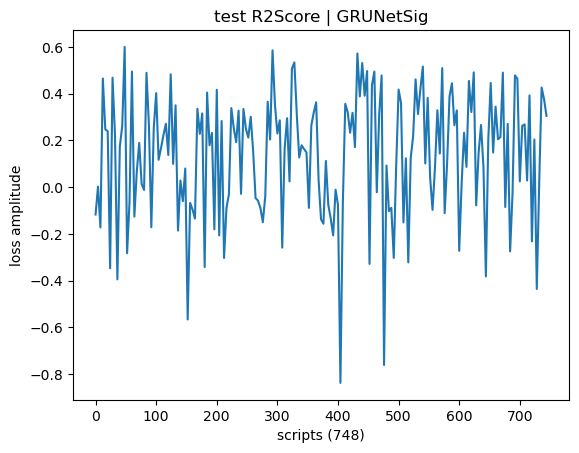

In [683]:
print(len(train_dataloader.dataset), len(test_dataloader.dataset))
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
start_time = time.time()
criterion = R2Score().to(device)
predictions, loss = evaluate(criterion, seqModel, test_dataloader, computeEachBsLoss=False, use_pack=True, with_prob=True)
print("--- %s seconds ---" % (time.time() - start_time)) #0.5718670642756402

In [204]:
import sys
torch.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)
def reconstruct_output(list_of_pred, batch_first, loss_list=None):
    inp_and_out = []
    if loss_list!=None:
        for p_list, loss_list in zip(list_of_pred, loss_list):
            inp, out, l = p_list
            out = torch.nn.utils.rnn.unpad_sequence(out, l, batch_first)
            if type(inp) is torch.nn.utils.rnn.PackedSequence:
                inp, _ = torch.nn.utils.rnn.pad_packed_sequence(inp)
            inp = torch.nn.utils.rnn.unpad_sequence(inp, l, batch_first)
            for i, o, lo in zip(inp, out, loss_list):
                inp_and_out.append((i, o, lo))
    else:
        for inp, out, l in list_of_pred:
            if type(inp) is torch.nn.utils.rnn.PackedSequence:
                inp, _ = torch.nn.utils.rnn.pad_packed_sequence(inp)
            print(inp.shape, out.shape)
            out = torch.nn.utils.rnn.unpad_sequence(out, l, batch_first)
            inp = torch.nn.utils.rnn.unpad_sequence(inp, l, batch_first)
            for i, o in zip(inp, out):
                inp_and_out.append((i, o))
    return inp_and_out

dic = {}
inp_and_out = reconstruct_output(predictions, False)
dic = get_au_dictionary(dataset)
print(len(dic))

torch.Size([440, 4, 17]) torch.Size([440, 4, 52])
torch.Size([634, 4, 17]) torch.Size([634, 4, 52])
torch.Size([619, 4, 17]) torch.Size([619, 4, 52])
torch.Size([516, 4, 17]) torch.Size([516, 4, 52])
torch.Size([384, 4, 17]) torch.Size([384, 4, 52])
torch.Size([426, 4, 17]) torch.Size([426, 4, 52])
torch.Size([511, 4, 17]) torch.Size([511, 4, 52])
torch.Size([697, 4, 17]) torch.Size([697, 4, 52])
torch.Size([705, 4, 17]) torch.Size([705, 4, 52])
torch.Size([863, 4, 17]) torch.Size([863, 4, 52])
torch.Size([769, 4, 17]) torch.Size([769, 4, 52])
torch.Size([618, 4, 17]) torch.Size([618, 4, 52])
torch.Size([562, 4, 17]) torch.Size([562, 4, 52])
torch.Size([527, 4, 17]) torch.Size([527, 4, 52])
torch.Size([351, 4, 17]) torch.Size([351, 4, 52])
torch.Size([758, 4, 17]) torch.Size([758, 4, 52])
torch.Size([704, 4, 17]) torch.Size([704, 4, 52])
torch.Size([403, 4, 17]) torch.Size([403, 4, 52])
torch.Size([432, 4, 17]) torch.Size([432, 4, 52])
torch.Size([379, 4, 17]) torch.Size([379, 4, 52])


In [205]:
torch.set_printoptions(precision=6)

np.set_printoptions(threshold=sys.maxsize)
for inp, pred in inp_and_out:
    np_array = inp.cpu().data.numpy()
    keys = [k for k, v in dic.items() if v.to_numpy().shape == np_array.shape and np.allclose(v.to_numpy(), np_array, atol=0.00001)]
    print(keys)


['b1b83ec4-bab9-599e-b08c-bde7ca309410!low!EMOTION100_083']
['b6339c18-81a7-5514-837d-ef939f47ebdc!low!EMOTION100_036']
['cf47777e-0fbe-54a3-9afd-4295f70e7975!low!EMOTION100_034']
['fd6a5b67-a87b-54dc-8c7d-90b4334c4921!low!EMOTION100_092']
['ceb7880c-1fc0-56cd-98b7-8ee92d9467eb!low!EMOTION100_071']
['fd6a5b67-a87b-54dc-8c7d-90b4334c4921!low!EMOTION100_073']
['1e3ce60a-3f76-5098-8be0-82e341ee9541!low!EMOTION100_046']
['3981b034-eb04-517e-abbc-900244f15c11!low!EMOTION100_073']
['3981b034-eb04-517e-abbc-900244f15c11!low!EMOTION100_006']
['3981b034-eb04-517e-abbc-900244f15c11!low!EMOTION100_063']
['b6339c18-81a7-5514-837d-ef939f47ebdc!low!EMOTION100_049']
['cf47777e-0fbe-54a3-9afd-4295f70e7975!low!EMOTION100_004']
['082b6e2e-1998-5c3c-892f-5cef247522d6!low!EMOTION100_027']
['082b6e2e-1998-5c3c-892f-5cef247522d6!low!EMOTION100_065']
['b6339c18-81a7-5514-837d-ef939f47ebdc!low!EMOTION100_020']
['1e3ce60a-3f76-5098-8be0-82e341ee9541!low!vowel_4']
['b1b83ec4-bab9-599e-b08c-bde7ca309410!low!EMOT

In [206]:
import os

def save_results(dataframe, inp_and_out, dic, folder, bs_only=True):
    for au, pred in inp_and_out:
        au_np = au.cpu().data.numpy()
        keys = [k for k, v in dic.items() if v.to_numpy().shape == au_np.shape and np.allclose(v.to_numpy(), au_np, atol=0.00001)]
        columns = dataframe.columns[-61:]
        if bs_only:
            columns = columns[:-9] #remove 9 last columns
        df = pd.DataFrame(columns=columns, data=pred.cpu().data.numpy())
        df.to_csv("predictions/" + folder +'_pred_'+keys[0]+'.csv', index=False)

def save_individual_csv_by_intensity_type(input_df, folder_path):
    columns = input_df.columns[-61:]
    groups = input_df.groupby('script_id').groups
    for script_id, idx in groups.items():
        full_df = input_df.iloc[idx]
        bs = full_df.iloc[:, -61:]
        df = pd.DataFrame(columns=columns, data=bs)
        full_path = os.path.join(path, "..", "individual_after_preprocessing", folder_path)
        full_path = os.path.normpath(full_path) #allows to use ".." in full path to go up one directory
        df.to_csv(full_path + '/' +  script_id + '.csv', index=False)

save_results(dataset, inp_and_out, dic, "model0.1_pred_low/", bs_only=True)

In [379]:
def train_eval_models():
    crits = [nn.L1Loss, nn.MSELoss, RMSELoss]
    models = [GRUNetSig, FCNet, GRUNetSeq, GRUNetAtt]
    n_epochs=100
    for model_to_init in models:
        print(f"model {model_to_init}")
        for crit_to_init in crits:
            model = model_to_init(input_size, hidden_size, output_size).to(device)
            if model_to_init== GRUNetSeq or model_to_init == GRUNetAtt:
                n_epochs = 10
            criterion = crit_to_init().to(device)
            print(criterion)
            model.apply(init_weights)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            start_time = time.time()
            model.train_(train_dataloader, n_epochs=n_epochs, criterion=criterion, optimizer=optimizer)
            print("--- %s seconds ---" % (time.time() - start_time))
            plt.savefig(f"loss/{model.__class__.__name__}_train_{criterion.__class__.__name__}.png")
            plt.cla()
            plt.close()
            
            eval_crits = [crit_to_init, R2Score, nn.CosineSimilarity]
            for eval_crit in eval_crits:
                if eval_crit == nn.CosineSimilarity:
                    eval_criterion = eval_crit(dim=0).to(device)
                else:
                    eval_criterion = eval_crit().to(device)
                if model_to_init == GRUNetPack or model_to_init == GRUNetSeq or model_to_init == GRUNetAtt:
                    evaluate(eval_criterion, model, test_dataloader, False, True, False)
                elif model_to_init == GRUNetSig:
                    evaluate(eval_criterion, model, test_dataloader, False, True, True)
                else:
                    evaluate(eval_criterion, model, test_dataloader, False, False, False)
                plt.savefig(f"loss/{model.__class__.__name__}_trained_with_{criterion.__class__.__name__}_test_{eval_criterion.__class__.__name__}.png")
                plt.cla()
                plt.close()
                print("\n")
        print("\n\n")

with open('out.md', 'w') as f:
    with redirect_stdout(f):
        train_eval_models()

RuntimeError: Function 'CudnnRnnBackward0' returned nan values in its 1th output.

In [ ]:
from pprint import pprint
from pathlib import Path
from collections import Counter
pd.set_option('display.max_colwidth', None)


def remove_unique_values(list_of_lists):
    flattened_list = [Path(item).name.split("/")[0] for sublist in list_of_lists for item in sublist]
    element_count = Counter(flattened_list)
    flattened_list_with_path = [item for sublist in list_of_lists for item in sublist]
    non_unique_elements = [element for element, count in element_count.items() if count > 8]
    modified_flattened_list = [element for element in flattened_list if element in non_unique_elements]
    modified_with_path = [item for item in flattened_list_with_path if Path(item).name.split("/")[0] in modified_flattened_list]
    list_of_scripts = []
    old_key = modified_with_path[0].rsplit('/', 2)[1].split('\\')[0]
    sublist =  []
    for i, item in enumerate(modified_with_path):
        key = item.rsplit('/', 2)[1].split('\\')[0]
        if key == old_key:
            sublist.append(item)
        else:
            list_of_scripts.append(list(sublist))
            sublist.clear()
            old_key = key
            sublist.append(item)
    list_of_scripts.append(list(sublist)) #append last sublist that was not added
    
    return list_of_scripts

def compare_predictions(bs_name):
    pred_folder = "predictions/"
    pred_folders = [[fil.path for fil in os.scandir(folder)] for folder in os.scandir(pred_folder) if folder.is_dir()]
    removed_uniques = remove_unique_values(pred_folders)
    for num_scripts in range(0, len(removed_uniques[0])):
        #for ground truth bs
        script_n = Path(removed_uniques[0][num_scripts]).name
        script_n = script_n.split("_", 2)[2].split(".csv")[0]
        df_script = (dataset["script_id"] == script_n)
        jaw_open_bs = dataset[df_script][bs_name]
        fig = plt.figure(figsize=(15, 10))
        plt.plot(np.arange(0, jaw_open_bs.shape[0]), jaw_open_bs, color="green", label="gt")
        plt.xlabel("frames")
        plt.ylabel("amplitude")
        for num_folders in range(0, len(removed_uniques)):
            if num_folders == 1:
                df_predictions = pd.read_csv(removed_uniques[num_folders][num_scripts])
                jaw_open_bs_pred = df_predictions[bs_name]
                model = removed_uniques[num_folders][num_scripts].rsplit('/', 2)[1].split('\\')[0]
                model = model.split("_")[0]     
                plt.plot(np.arange(jaw_open_bs.shape[0]),jaw_open_bs_pred, linestyle="dashdot", label=model)
                plt.legend(loc="upper right")
                plt.title(script_n + f"\n{bs_name}")
        display(fig)
        # plt.savefig("model comparison/model_comparison_" + script_n + ".png")
        # plt.cla()
        # plt.close()
        


compare_predictions("JawOpen")

In [198]:
torch.save(seqModel.state_dict(), 'pytorch models/grunet-low.pth')